# Introduction

We analyze data from [Amadei et al. 2022](https://doi.org/10.1038/s41586-022-05246-3). In their figure S10, they compared the RNA velocity of natural and synthetic embyro.

# Preprocessing


In [26]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *
from models.two_species import get_Y

/home/mffang/workspace/Poisson-regression/RADOM


In [27]:
import time
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import scanpy as sc
import os
import anndata as ad

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [28]:
dir_name = "/home/mffang/data/counts/Amadei/"

### Metadata of the dataset

In [29]:
files = os.listdir(dir_name+"GSE189425_RAW")
files = np.sort(files)
their_files = []
embryos = []
for file in files:
    if file[:3]=="GSM":
        their_files.append(file)
        if file[11]=="E":
            embryos.append("ETiX")
        else:
            embryos.append("NE")

In [30]:
SRR_dirs = ["SRR17020603","SRR17020602","SRR17020601","SRR17020600","SRR17020599","SRR17020598","SRR17020597",
            "SRR17020596","SRR17020595","SRR17020594","SRR17020593","SRR17020592","SRR17020591","SRR17020590",
            "SRR17020589","SRR17020588","SRR17020587","SRR17020586","SRR17020585","SRR17020584","SRR17020583",
            "SRR17020582","SRR17020581","SRR17020608","SRR17020607","SRR17020606","SRR17020605","SRR17020604"]
days = [5,5,5,6,6,6,6,6,6,8,8,8,8,8,8,8,8,6.5,6.5,6.5,6.5,8.5,8.5,8.5,8.5,8.5,8.5,8.5]

In [31]:
metadata = pd.DataFrame({"their_files":their_files,"SRR_dirs":SRR_dirs,"embryos":embryos,"days":days})
metadata

,their_files,SRR_dirs,embryos,days
0,GSM5701522_ETiX_d5_1.inex.txt,SRR17020603,ETiX,5.0
1,GSM5701523_ETiX_d5_2.inex.txt,SRR17020602,ETiX,5.0
2,GSM5701524_ETiX_d5_3.inex.txt,SRR17020601,ETiX,5.0
3,GSM5701525_ETiX_d6_1.inex.txt,SRR17020600,ETiX,6.0
4,GSM5701526_ETiX_d6_2.inex.txt,SRR17020599,ETiX,6.0
5,GSM5701527_ETiX_d6_3.inex.txt,SRR17020598,ETiX,6.0
6,GSM5701528_ETiX_d6_4.inex.txt,SRR17020597,ETiX,6.0
7,GSM5701529_ETiX_d6_5.inex.txt,SRR17020596,ETiX,6.0
8,GSM5701530_ETiX_d6_6.inex.txt,SRR17020595,ETiX,6.0
9,GSM5701531_ETiX_d8_1.inex.txt,SRR17020594,ETiX,8.0


In [32]:
def hamming_distance(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Strand lengths are not equal!")
    return sum(ch1 != ch2 for ch1,ch2 in zip(s1,s2))

**check whitelist**

In [117]:
whitelist = np.loadtxt("/home/mffang/data/counts/Amadei/indrops_version3_whitelist.txt",dtype=str)

In [11]:
their_data = sc.read("/home/mffang/data/counts/Amadei/GSE189425_RAW/GSM5701544_NE85_2.inex.txt")
their_data = their_data.T
their_data

AnnData object with n_obs × n_vars = 9122 × 24509

In [119]:
their_barcodes = []
for name in list(their_data.obs_names):
    barcode = name.split('_')[3]
    their_barcodes.append(barcode[:8]+barcode[-8:])

In [120]:
inwhitelist = [their_barcodes[i] in whitelist for i in range(len(their_barcodes))]
print(np.sum(inwhitelist))

8856


Therefore, the default whitelist does not contain all barcodes

**generate whitelist**

In [132]:
files = os.listdir(dir_name)
whitelist = []
for file in files:
    if file[:3]=="GSM":
        print(file)
        df = pd.read_csv(dir_name+file, delimiter = "\t")
        for name in list(df.columns):
            barcode = name.split('_')[-1]
            barcode = barcode[:8]+barcode[-8:]
            if barcode not in whitelist:
                whitelist.append(barcode)
        print(len(whitelist))

GSM5701532_ETiX_d8_2.inex.txt
10294
GSM5701546_NE85_4.inex.txt
20985
GSM5701535_ETiX_d8_5.inex.txt
31793
GSM5701523_ETiX_d5_2.inex.txt
35427
GSM5701522_ETiX_d5_1.inex.txt
39092
GSM5701545_NE85_3.inex.txt
46435
GSM5701529_ETiX_d6_5.inex.txt
52973
GSM5701537_ETiX_d8_EXE_1.inex.txt
60247
GSM5701534_ETiX_d8_4.inex.txt
68212
GSM5701547_NE85_5.inex.txt
72519
GSM5701548_NE85_6.inex.txt
76507
GSM5701542_NE75_2.inex.txt
80188
GSM5701549_NE85_EXE.inex.txt
85956
GSM5701526_ETiX_d6_2.inex.txt
87092
GSM5701528_ETiX_d6_4.inex.txt
88637
GSM5701541_NE75_1.inex.txt
90875
GSM5701531_ETiX_d8_1.inex.txt
93477
GSM5701533_ETiX_d8_3.inex.txt
96507
GSM5701539_NE65_1.inex.txt
97549
GSM5701524_ETiX_d5_3.inex.txt
98700
GSM5701538_ETiX_d8_EXE_2.inex.txt
101867
GSM5701536_ETiX_d8_6.inex.txt
105479
GSM5701540_NE65_2.inex.txt
106163
GSM5701525_ETiX_d6_1.inex.txt
106917
GSM5701543_NE85_1.inex.txt
108579
GSM5701544_NE85_2.inex.txt
109723
GSM5701530_ETiX_d6_6.inex.txt
110759
GSM5701527_ETiX_d6_3.inex.txt
111291


In [143]:
whitelist = np.sort(whitelist)

In [146]:
np.savetxt("/home/mffang/counts/Amadei/Amadei_whitelist.txt",whitelist,fmt="%s",delimiter='\n')

In [44]:
our_data = sc.read("/home/mffang/data/counts/Amadei/SRR17020581/counts_unfiltered/adata.h5ad")
our_data

AnnData object with n_obs × n_vars = 69161 × 55471
    var: 'gene_name'
    layers: 'spliced', 'unspliced'

In [45]:
our_data.X.sum()+our_data.layers['unspliced'].sum()

12649741.0

In [46]:
their_data = sc.read("/home/mffang/data/counts/Amadei/GSE189425_RAW/GSM5701544_NE85_2.inex.txt")
their_data = their_data.T
their_data

AnnData object with n_obs × n_vars = 9122 × 24509

In [47]:
their_data.X.sum()

9792618.0

In [48]:
their_barcodes = []
for name in list(their_data.obs_names):
    barcode = name.split('_')[3]
    assert hamming_distance(barcode[8:16],"TCGCTATG")<=1, barcode[8:16]
    their_barcodes.append(barcode[:8]+barcode[-8:])
their_data.obs["barcode"]=their_barcodes

In [49]:
their_gene_ID = []
gene_names = []
for name in list(their_data.var_names):
    ID, gene_name = name.split('_')
    their_gene_ID.append(ID)
    gene_names.append(gene_name)
ID2names = dict(zip(their_gene_ID,gene_names))
len(their_gene_ID)

24509

In [53]:
gene_indices = []
for i,t in enumerate(our_data.var_names):
    gene = t.split('.')[0]
    if gene in ID2names:
        gene_indices.append(i)

In [54]:
adata = our_data[our_data.obs_names.isin(their_barcodes),:]
adata = adata[:,gene_indices]
adata

View of AnnData object with n_obs × n_vars = 8856 × 24509
    var: 'gene_name'
    layers: 'spliced', 'unspliced'

In [55]:
adata.X.sum(axis=1).mean()

556.79877

In [57]:
their_data.X.sum(axis=1).mean()

1073.5166

In [58]:
sc.pp.filter_cells(adata, min_genes=0)
sc.pp.filter_genes(adata, min_cells=0)
sc.pp.filter_cells(adata, min_counts=0)
adata

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 8856 × 24509
    obs: 'n_genes', 'n_counts'
    var: 'gene_name', 'n_cells'
    layers: 'spliced', 'unspliced'

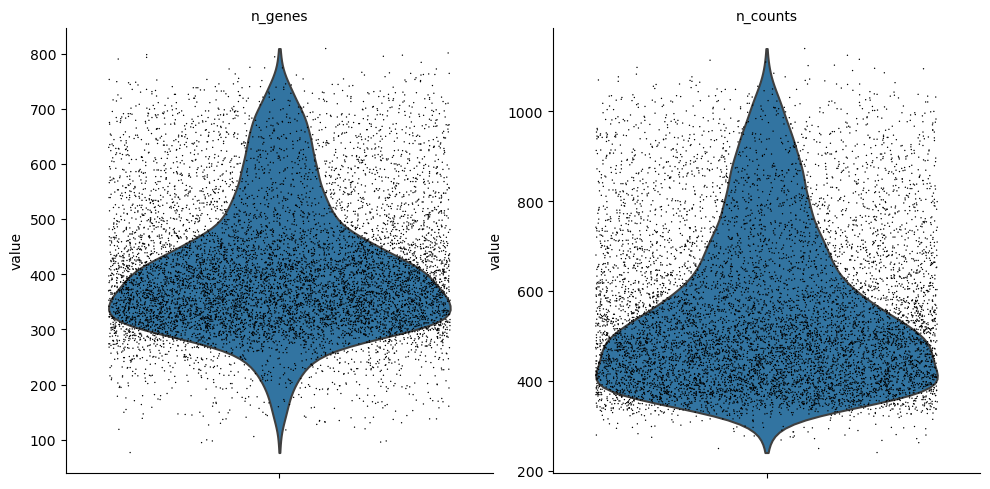

In [59]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

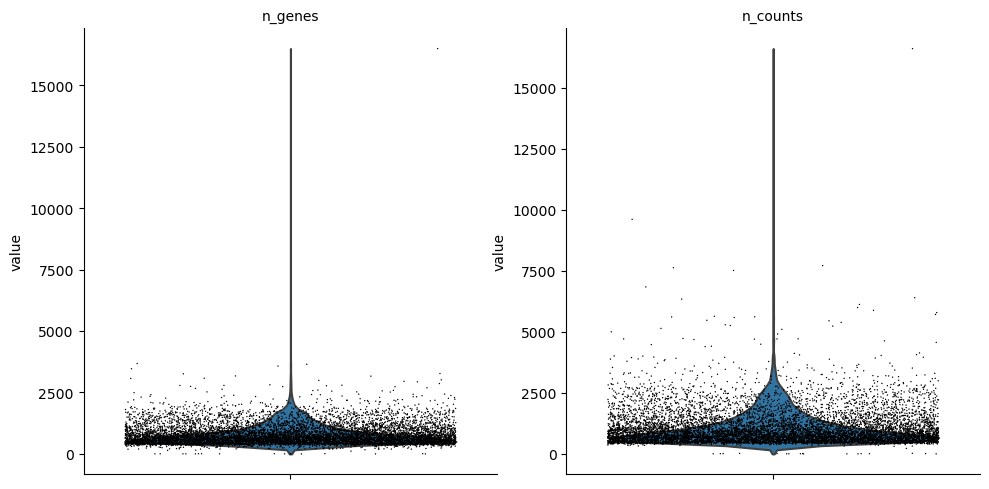

In [60]:
sc.pp.filter_cells(their_data, min_genes=0)
sc.pp.filter_genes(their_data, min_cells=0)
sc.pp.filter_cells(their_data, min_counts=0)
sc.pl.violin(their_data, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

In [70]:
idx = [np.where( their_data.obs["barcode"]== bc)[0][0] for bc in adata.obs_names]

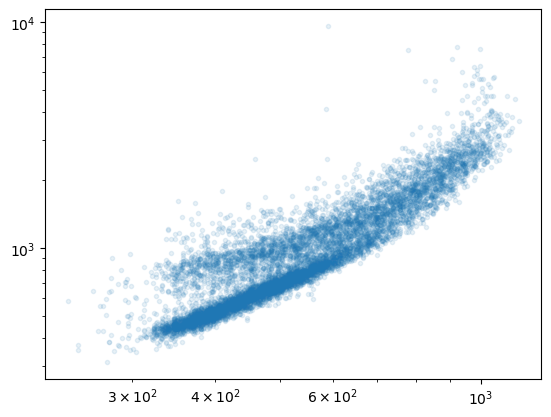

In [76]:
plt.loglog(adata.obs['n_counts'],their_data.obs['n_counts'][idx],'.',alpha=0.1);

# Analysis

## Concatenate data

In [ ]:
adatas = []
for i, their_file in enumerate(their_files):
    print("files:",their_file,SRR_dirs[i])
    ## read their file
    their_data = sc.read(dir_name + "GSE189425_RAW/" + their_file)
    their_data = their_data.T
    
    ## read our file with SRR number    
    our_data = sc.read(dir_name + SRR_dirs[i] + "/counts_unfiltered/adata.h5ad")
    
    ## get the barcode and gene indice
    their_barcodes = []
    for name in list(their_data.obs_names):
        barcode = name.split('_')[-1]
        their_barcodes.append(barcode[:8]+barcode[-8:])
    
    their_gene_ID = []
    their_gene_names = []
    for name in list(their_data.var_names):
        ID, gene_name = name.split('_')
        their_gene_ID.append(ID)
        their_gene_names.append(gene_name)
    ID2names = dict(zip(their_gene_ID,their_gene_names))
    
    ## slice matrix
    adata = our_data[our_data.obs_names.isin(their_barcodes),:]
    
    gene_indices = []
    gene_names = []
    for j,t in enumerate(our_data.var_names):
        gene = t.split('.')[0]
        if gene in ID2names:
            gene_indices.append(j)
            gene_names.append(ID2names[gene])
    adata = adata[:,gene_indices]
    print("adata shape: ", adata.shape)
    
    ## add meta information
    adata.obs.index = adata.obs.index  + '_' + str(i)
    adata.obs["SRR"] = SRR_dirs[i]
    adata.obs["embryos"] = embryos[i]
    adata.obs["days"] = days[i]   
    adata.var["gene_names"] = gene_names
    adatas.append(adata)

In [79]:
adata = ad.concat(adatas, join="outer")
adata

AnnData object with n_obs × n_vars = 252954 × 36408
    obs: 'SRR', 'embryos', 'days'
    layers: 'spliced', 'unspliced'

In [80]:
adata.write_loom("../data/Amadei.loom")

In [34]:
adata = sc.read("../data/Amadei.loom")
raw_data = adata.copy()

In [35]:
sc.pp.filter_cells(adata, min_genes=500)
adata

AnnData object with n_obs × n_vars = 53954 × 36408
    obs: 'SRR', 'days', 'embryos', 'n_genes'
    layers: 'matrix', 'spliced', 'unspliced'

In [36]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, max_value=10)

In [37]:
sc.tl.pca(adata, svd_solver='arpack') 

... storing 'SRR' as categorical
... storing 'embryos' as categorical


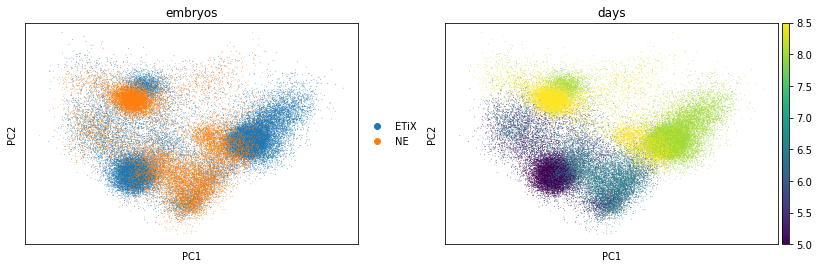

In [38]:
sc.pl.pca(adata,color=["embryos","days"])

In [39]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30) 
sc.tl.umap(adata) 

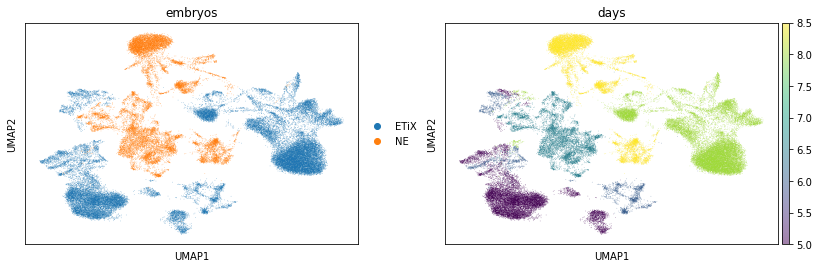

In [40]:
sc.pl.umap(adata,color=["embryos","days"],alpha=0.5)

# Trajectory

In [41]:
sc.pp.highly_variable_genes(adata,n_top_genes=20,flavor='seurat_v3')

/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/home/mffang/miniconda3/envs/python_3.9/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:83: RuntimeWarning: invalid value encountered in log10
  x = np.log10(mean[not_const])


ValueError: b'Extrapolation not allowed with blending'

In [ ]:
idx = adata.var['highly_variable']
gene_list=adata.var['gene'][idx]
X=adata.X.toarray()
X=X[:,idx,None]
X.shape

In [8]:
tau=(0,1)
topo = np.array([[0],[1],[2]])
traj = Trajectory(topo, tau, model="one_species")
Q, elbos = traj.fit(X, n_init=1, parallel=True, n_threads=4, seed=63)

run method fit_multi_init
trial 1


100%|███████████████████████████████████████████| 20/20 [00:14<00:00,  1.35it/s]


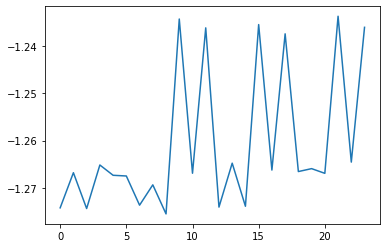

In [9]:
plt.plot(elbos)

In [12]:
plot_idx = gene_list.isin(['bcd','eve','med','hunchback'])
gene_list[plot_idx]

Series([], Name: gene, dtype: object)

In [ ]:
plt.plot(elbos)